<a href="https://colab.research.google.com/github/tkusak27/nfl-spreads-ai/blob/main/nfl_spreads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [391]:
# imports
import os, sys, requests
import tqdm
import tqdm, csv
import pandas as pd
import numpy as np
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, MultiTaskLasso, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import statistics
from sklearn.decomposition import PCA

# Master Information

In [72]:
CURRENT_WEEK = 13

# Reading Spreadsheet into DF


In [64]:
# reading spreadsheet
# Authenticate Google Credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open worksheet and record in Pandas DF
worksheet = gc.open('nfl-spreads').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

# Master Data Dictionary

In [303]:
from collections import defaultdict

# Initializing our master dictionary
def initialize_team():
    return {
        'scores': [0],
        'against': [0],
        'opponents': [0],
        'record': [0],
        'spreads': [0],
        'moneylines': [0],
        'games': 0,
        'wins': 0,
        'losses': 0,
        'covers': 0,
        'overs': 0,
        'w_streak': 0,
        'l_streak': 0,
        'c_streak': 0,
        'ou_streak': 0
    }

teams_data = defaultdict(initialize_team)

# Function to update the dictionary by row - can be used later
def update_dict(dictionary, row):
  week = row['week']
  home_team = row['home']
  away_team = row['away']
  home_spread = float(row['home_spread'])
  away_spread = float(row['away_spread'])
  home_ml = int(row['home_ml'])
  away_ml = int(row['away_ml'])
  home_score = int(row['home_score'])
  away_score = int(row['away_score'])
  ou = float(row['ou'])

  # Intialize if not in dict
  if home_team not in teams_data:
    dictionary[home_team]
  if away_team not in teams_data:
    dictionary[away_team]

  # Update dictionary
  dictionary[home_team]['scores'].append(home_score)
  dictionary[away_team]['scores'].append(away_score)
  dictionary[home_team]['against'].append(away_score)
  dictionary[away_team]['against'].append(home_score)
  dictionary[home_team]['opponents'].append(away_team)
  dictionary[away_team]['opponents'].append(home_team)
  dictionary[home_team]['spreads'].append(home_spread)
  dictionary[away_team]['spreads'].append(away_spread)
  dictionary[home_team]['moneylines'].append(home_ml)
  dictionary[away_team]['moneylines'].append(away_ml)

  dictionary[home_team]['games'] += 1
  dictionary[away_team]['games'] += 1

  # Update dictionary win/loss
  if home_score > away_score:
    dictionary[home_team]['record'].append(1)
    dictionary[away_team]['record'].append(-1)

    dictionary[home_team]['wins'] += 1
    dictionary[away_team]['losses'] += 1
    dictionary[home_team]['w_streak'] += 1
    dictionary[home_team]['l_streak'] = 0
    dictionary[away_team]['w_streak'] = 0
    dictionary[away_team]['l_streak'] += 1
  elif home_score < away_score:
    dictionary[home_team]['record'].append(-1)
    dictionary[away_team]['record'].append(1)

    dictionary[home_team]['losses'] += 1
    dictionary[away_team]['wins'] += 1
    dictionary[home_team]['w_streak'] = 0
    dictionary[home_team]['l_streak'] += 1
    dictionary[away_team]['w_streak'] += 1
    dictionary[away_team]['l_streak'] = 0
  else:
    dictionary[home_team]['record'].append(0)
    dictionary[away_team]['record'].append(0)

  # Update dictionary spreads
  if home_score + home_spread > away_score:
    dictionary[home_team]['spreads'].append(1)
    dictionary[away_team]['spreads'].append(-1)

    dictionary[home_team]['covers'] += 1

    dictionary[home_team]['c_streak'] += 1
    dictionary[away_team]['c_streak'] = 0
  elif home_score + home_spread < away_score:
    dictionary[home_team]['spreads'].append(-1)
    dictionary[away_team]['spreads'].append(1)

    dictionary[away_team]['covers'] += 1

    dictionary[home_team]['c_streak'] = 0
    dictionary[away_team]['c_streak'] += 1

  # Update dictionary over unders
  if home_score + away_score > ou:
    dictionary[home_team]['overs'] += 1
    dictionary[away_team]['overs'] += 1
    dictionary[home_team]['ou_streak'] += 1
    dictionary[away_team]['ou_streak'] += 1
  elif home_score + away_score < ou:
    dictionary[home_team]['ou_streak'] = 0
    dictionary[away_team]['ou_streak'] = 0

# In action
for index, row in df.iterrows():
  update_dict(dictionary=teams_data, row=row)

# teams_data is now a master dictionary containing data for each team
print(teams_data)

defaultdict(<function initialize_team at 0x7bd806dae170>, {'Chiefs': {'scores': [0, 20, 17, 41, 23, 27, 19, 31, 9, 21, 17, 31, 19], 'against': [0, 21, 9, 10, 20, 20, 8, 17, 24, 14, 21, 17, 27], 'opponents': [0, 'Lions', 'Jaguars', 'Bears', 'Jets', 'Vikings', 'Broncos', 'Chargers', 'Broncos', 'Dolphins', 'Eagles', 'Raiders', 'Packers'], 'record': [0, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1], 'spreads': [0, -3.5, -1, -3.5, 1, -12.5, 1, -7.5, -1, -3.5, 1, -10.5, 1, -5.5, 1, -7.0, -1, 1.0, 1, -2.5, -1, -9.5, 1, -5.5, -1], 'moneylines': [0, -210, -172, -720, -390, -176, -590, -260, -350, -108, -154, -480, -245], 'games': 12, 'wins': 8, 'losses': 4, 'covers': 7, 'overs': 4, 'w_streak': 0, 'l_streak': 1, 'c_streak': 0, 'ou_streak': 2}, 'Lions': {'scores': [0, 21, 31, 20, 34, 42, 20, 6, 26, 41, 31, 22, 33], 'against': [0, 20, 37, 6, 20, 24, 6, 38, 14, 38, 26, 29, 28], 'opponents': [0, 'Chiefs', 'Seahawks', 'Falcons', 'Packers', 'Panthers', 'Buccaneers', 'Ravens', 'Raiders', 'Chargers', 'Bears',

# Big-picture spread trends (no AI involved)

In [73]:
# analyzing spreads
games = 0
# Home favorites
hfws = 0
hfls = 0
hf_comp_ml = 0
hfg = 0
# spreads
hsfg = 0
hsfc = 0
hsf_comp = 0
# Away favorites
afws = 0
afls = 0
af_comp_ml = 0
afg = 0
# spreads
asfg = 0
asfc = 0
asf_comp = 0

for index, row in df.iterrows():
  games += 1

  home_spread = float(row['home_spread'])
  away_spread = float(row['away_spread'])

  home_ml = int(row['home_ml'])
  away_ml = int(row['away_ml'])

  home_score = int(row['home_score'])
  away_score = int(row['away_score'])

  # if home is the favorite
  if home_ml <= away_ml:
    hfg += 1
    hf_comp_ml += home_ml
    # home wins
    if home_score > away_score:
      hfws += 1
    else:
      hfls += 1
  # away is the favorite
  else:
    afg += 1
    af_comp_ml += away_ml
    # home wins
    if home_score > away_score:
      afls += 1
    else:
      afws += 1

  if home_spread <= away_spread:
    hsfg += 1
    hsf_comp += home_spread
    if home_score + home_spread > away_score:
       hsfc += 1
  else:
    asfg += 1
    asf_comp += away_spread
    if away_score + away_spread > home_score:
      asfc += 1


print(f"Home favorites win {100 * (hfws / hfg):.2f}% of the time and on average odds are {(hf_comp_ml / hfg):.2f}")
print(f"Away favorites win {100 * (afws / afg):.2f}% of the time and on average odds are {(af_comp_ml / afg):.2f}" )

print(f"Home spread favorites cover {100 * (hsfc / hsfg):.2f}% of the time and on average odds are {(hsf_comp / hsfg):.2f}")
print(f"Away spread favorites cover {100 * (asfc / asfg):.2f}% of the time and on average odds are {(asf_comp / asfg):.2f}")

Home favorites win 70.54% of the time and on average odds are -316.29
Away favorites win 67.95% of the time and on average odds are -207.87
Home spread favorites cover 52.73% of the time and on average odds are -5.56
Away spread favorites cover 55.00% of the time and on average odds are -3.79


# Big-picture over-under trends (no AI involved)

In [74]:
weeks   = []
ous     = []
hits    = []

totals = defaultdict(list)

# grab totals data
for index, row in df.iterrows():
  week = int(row['week'])
  id = int(row['game_id'])
  total = float(row['total'])
  ou = float(row['ou'])

  if week not in totals:
    totals[week] = []

  if total > ou:
    totals[week].append((id, 1, total - ou, ou))
  elif total == ou:
    totals[week].append((id, 0, total - ou, ou))
  else:
    totals[week].append((id, -1, total - ou, ou))


winners, differences = [], []
weekly_averages = []
for key, value in totals.items():
  winners.append(sum(tup[1] for tup in value))
  differences.append(sum(tup[2] for tup in value))
  weekly_averages.append(sum(tup[3] for tup in value)/len(value))

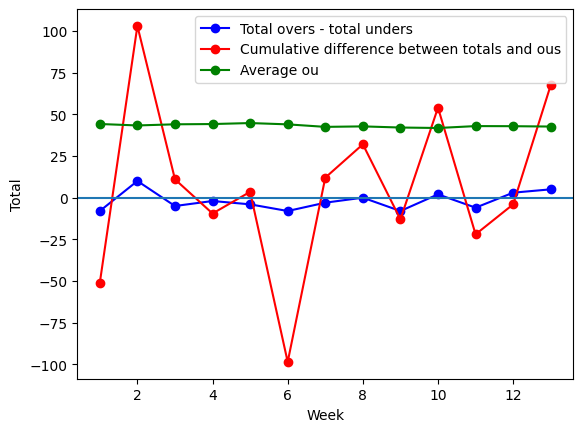

In [75]:
plt.plot(totals.keys(), winners, color = 'blue', marker='o', label='Total overs - total unders')
plt.plot(totals.keys(), differences, color = 'red', marker ='o', label='Cumulative difference between totals and ous')
plt.plot(totals.keys(), weekly_averages, color = 'green', marker ='o', label='Average ou')
plt.xlabel('Week')
plt.ylabel('Total')
plt.legend()
plt.axhline()
plt.show()

# Spreads - Classifer Testing

In [390]:
# Redoing
# Want to test data vs labels
# Data: home spread
# Label: Cover vs no cover

def run_spreads(fade=False):
  MY_RANDOM_STATE = 26

  tags =        ["LR", "LDA", "DTC", "KNN", "GNB", "GBC"]

  spread_results = defaultdict(list)

  # Need a live_data dictionary because we want the classifier
  # to test on the current week's attributes, not the overall
  # results store in the teams_data master dictionary
  # aka we don't want week 9 results when we test week 3
  # (because we only want to test week 3 on weeks 1 and 2)
  live_data = defaultdict(initialize_team)

  xtrain = []
  ytrain = []
  test_tags = []

  # iterate through the weeks
  for i in range(1, CURRENT_WEEK + 1):
    last_week = i - 1
    test_week = i
    xtest = []
    actual = []

    # iterate through the df - only using the weeks we want
    for index, row in df.iterrows():
      week = int(row['week'])

      # if its the correct week - let's update the dictionary with that week's data
      if week == last_week:
        update_dict(dictionary=live_data, row=row)

    # now we have an updated dictinoary with accurate data (up to that week)

  # print(f"test week {test_week} using {live_data}")

    # go back and create the training data for the current week
    for index, row in df.iterrows():
      week = int(row['week'])
      home_team = (row['home'])
      away_team = (row['away'])
      home_score = int(row['home_score'])
      away_score = int(row['away_score'])
      home_spread = float(row['home_spread'])
      away_spread = float(row['away_spread'])


      appender = [
          week,
          home_spread,
          #away_spread,
          live_data[home_team]['wins'],
          live_data[away_team]['wins'],
          live_data[home_team]['covers'],
          live_data[away_team]['covers'],
          live_data[home_team]['w_streak'],
          live_data[away_team]['w_streak'],
          #live_data[home_team]['c_streak'],
          #live_data[away_team]['c_streak'],
          #live_data[home_team]['record'][-1],
          #live_data[away_team]['record'][-1],
          #live_data[home_team]['moneylines'][-1]

      ]


      # if it is a new week we want to add, add it to xtrain
      if week == last_week:
        xtrain.append(appender)
        if home_score + home_spread > away_score:
          ytrain.append("H")
        elif home_score + home_spread < away_score:
          ytrain.append("A")
        else:
          ytrain.append("H")

    #print(xtrain, ytrain)

      # now we have accurate training data, so lets get the testing data
      elif week == test_week:
        xtest.append(appender)
        test_tags.append(int(row['game_id']))
        if home_score + home_spread > away_score:
          actual.append("H")
        elif home_score + home_spread < away_score:
          actual.append("A")
        else:
          actual.append("H")


    # now we have an accurate set of data to train and test (for each week), so let's test

    # skip testing week 1
    if test_week != 1:
      classifiers =   [ LogisticRegression(random_state=MY_RANDOM_STATE,max_iter=5000),
                        LinearDiscriminantAnalysis(),
                        DecisionTreeClassifier(random_state=MY_RANDOM_STATE),
                        KNeighborsClassifier(),
                        GaussianNB(),
                        GradientBoostingClassifier()]

      # For each classifier, fit, predict, and check results
      for (tag, classifier) in zip(tags, classifiers):
        classifier.fit(xtrain, ytrain)
        prediction = classifier.predict(xtest)

        # if the model is so bad and we want to fade the predictions,
        # flip the prediction values
        if fade:
          new_pred = []
          for i in range(len(prediction)):
            if prediction[i] == "H":
              new_pred.append("A")

            elif prediction[i] == "A":
              new_pred.append("H")

          accuracy = accuracy_score(actual, new_pred)
        else:
          accuracy = accuracy_score(actual, prediction)


        #print(prediction)
        spread_results[tag].append(accuracy)
  return spread_results

# Get spread results
spread_results = run_spreads(fade=False)
print("SPREAD CLASSIFER TESTING RESULTS")
output_table(spread_results)
print("\n")

SPREAD CLASSIFER TESTING RESULTS
                          LR       LDA      DTC      KNN      GNB      GBC      
Results for week  2:     0.56     0.44     0.62     0.44     0.56     0.50 
Results for week  3:     0.40     0.73     0.60     0.40     0.47     0.47 
Results for week  4:     0.38     0.25     0.50     0.38     0.50     0.44 
Results for week  5:     0.50     0.43     0.50     0.43     0.50     0.50 
Results for week  6:     0.50     0.50     0.50     0.43     0.57     0.50 
Results for week  7:     0.31     0.31     0.46     0.62     0.31     0.46 
Results for week  8:     0.62     0.69     0.56     0.56     0.38     0.62 
Results for week  9:     0.43     0.50     0.50     0.57     0.79     0.29 
Results for week 10:     0.57     0.57     0.50     0.57     0.50     0.64 
Results for week 11:     0.50     0.64     0.50     0.50     0.57     0.57 
Results for week 12:     0.60     0.53     0.40     0.60     0.80     0.47 
Results for week 13:     0.62     0.54     0.69   

# Over-unders - Classifer Testing

In [317]:
# Over under model - exact same process as spread model

def run_ous(fade=False):
  MY_RANDOM_STATE = 26

  tags =        ["LR", "LDA", "DTC", "KNN", "GNB", "GBC"]

  ou_live_data = defaultdict(initialize_team)
  ou_results = defaultdict(list)

  xtrain = []
  ytrain = []
  test_tags = []

  last_week_overs_list = [0]
  last_week_overs = 0

  for i in range(1, CURRENT_WEEK + 1):
    last_week = i - 1
    test_week = i
    xtest = []
    actual = []


    for index, row in df.iterrows():
      week = int(row['week'])

      if week == last_week:
        update_dict(dictionary=ou_live_data, row=row)


    for index, row in df.iterrows():
      week = int(row['week'])
      home_team = (row['home'])
      away_team = (row['away'])
      home_score = int(row['home_score'])
      away_score = int(row['away_score'])
      ou = float(row['ou'])


      # data we are using to train
      appender = [
          ou,
          week,
          last_week_overs_list[last_week],
          #ou_live_data[home_team]['overs'],
          #ou_live_data[away_team]['overs'],
          #ou_live_data[home_team]['ou_streak'],
          #ou_live_data[away_team]['ou_streak'],

          # average points scored and points received
          sum(ou_live_data[home_team]['scores']) / len(ou_live_data[home_team]['scores']),
          sum(ou_live_data[away_team]['scores']) / len(ou_live_data[away_team]['scores']),
          sum(ou_live_data[home_team]['against']) / len(ou_live_data[home_team]['against']),
          sum(ou_live_data[away_team]['against']) / len(ou_live_data[away_team]['against']),

          # last week's score
          ou_live_data[home_team]['scores'][-1],
          ou_live_data[away_team]['scores'][-1],

          #
      ]

      total = home_score + away_score

      if week == last_week:
        xtrain.append(appender)
        if total > ou:
          ytrain.append("O")
        elif total < ou:
          ytrain.append("U")
        else:
          ytrain.append("O")

      elif week == test_week:
        xtest.append(appender)
        test_tags.append(int(row['game_id']))
        if total > ou:
          actual.append("O")
          last_week_overs += 1
        elif total < ou:
          actual.append("U")
        else:
          actual.append("O")
      # collect training data of all weeks except that one

    last_week_overs_list.append(last_week_overs)
    # skip week 1
    if test_week != 1:
      classifiers =   [ LogisticRegression(random_state=MY_RANDOM_STATE,max_iter=1000),
                        LinearDiscriminantAnalysis(),
                        DecisionTreeClassifier(random_state=MY_RANDOM_STATE),
                        KNeighborsClassifier(),
                        GaussianNB(),
                        GradientBoostingClassifier()]

      for (tag, classifier) in zip(tags, classifiers):
        classifier.fit(xtrain, ytrain)
        prediction = classifier.predict(xtest)

        # if the model is so bad and we want to fade the predictions,
        # flip the prediction values
        if fade:
          new_pred = []
          for i in range(len(prediction)):
            if prediction[i] == "O":
              new_pred.append("U")

            elif prediction[i] == "U":
              new_pred.append("O")

          accuracy = accuracy_score(actual, new_pred)
        else:
          accuracy = accuracy_score(actual, prediction)

        ou_results[tag].append(accuracy)

  return ou_results

# Outputting Functions

In [229]:
# output a chart of that data
def output_table(dictionary):
  space = " "
  print(f"{space:26}", end = "")
  for key in dictionary:
    print(f"{key:9}", end="")
  print()
  for i in range(2, CURRENT_WEEK + 1):
    print(f"Results for week {i:2}: ", end="")
    for key, value in dictionary.items():
      print(f"{value[i-2]:8.2f} ", end="")
    print()

  print()
  string = "Average accuracy: "
  print(f"{string:21}", end="")
  for value in dictionary.values():
    print(f"{(sum(value)/len(value)):8.2f} ", end="")

  print()
  string2 = "Standard deviation: "
  print(f"{string2:21}", end="")
  for value in dictionary.values():
    print(f"{statistics.pstdev(value):8.2f} ", end="")

In [230]:
# Calculate the overall return on these data points
# not entirely accurate - assumes the same amount of games played each week

def check_betting_results(dictionary, tags, bet_amt, weeks):
  VEGAS_CUT = (1/11)
  BET = weeks * bet_amt

  print(f"If you bet ${BET} across the last {weeks} weeks (${BET//weeks} per week), your net would be: ")

  for tag in tags:
    total = 0

    for percentage in dictionary[tag][len(dictionary[tag])-weeks:]:
      # how much you're betting per week
      value = BET / weeks
      earnings = value

      # you win the percentage of the bets
      earnings *= percentage
      earnings *= 1 - VEGAS_CUT

      # add what you earned from the bet
      total += earnings

      # subtract what you lost
      total -= (1-percentage) * value


    print(f"{tag}: a {'loss' if total < 0 else 'gain'} of ${abs(total):.2f}")


In [231]:
# plot the data

def graph_results(dictionary, tags):
  weeks = [i for i in range(2, CURRENT_WEEK + 1)]
  for i in range(len(tags)):
    plt.plot(weeks, dictionary[tags[i]], label=tags[i])
    plt.plot(weeks, [0.525 for _ in range(len(weeks))], label="52.5% Mark", color="black")
    plt.ylim(0, 1)
    plt.xlabel('Week')
    plt.ylabel('Total')
    plt.legend()
    plt.axhline()
    plt.show()

# Run Programs and Analysis

In [232]:
tags =        ["LR", "LDA", "DTC", "KNN", "GNB", "GBC"]

In [380]:
# Get spread results
spread_results = run_spreads(fade=False)
print("SPREAD CLASSIFER TESTING RESULTS")
output_table(spread_results)
print("\n")

SPREAD CLASSIFER TESTING RESULTS
                          LR       LDA      DTC      KNN      GNB      GBC      
Results for week  2:     0.56     0.44     0.62     0.44     0.56     0.56 
Results for week  3:     0.47     0.67     0.67     0.40     0.53     0.67 
Results for week  4:     0.38     0.38     0.44     0.31     0.25     0.44 
Results for week  5:     0.36     0.36     0.43     0.50     0.36     0.43 
Results for week  6:     0.43     0.50     0.36     0.50     0.50     0.36 
Results for week  7:     0.31     0.38     0.54     0.46     0.31     0.54 
Results for week  8:     0.44     0.44     0.38     0.56     0.44     0.38 
Results for week  9:     0.36     0.36     0.36     0.57     0.36     0.36 
Results for week 10:     0.57     0.57     0.64     0.57     0.50     0.64 
Results for week 11:     0.57     0.71     0.64     0.57     0.21     0.64 
Results for week 12:     0.60     0.47     0.60     0.53     0.60     0.60 
Results for week 13:     0.62     0.38     0.38   

In [377]:
# Get ou results
ou_results = run_ous(fade=False)
print("OU CLASSIFER TESTING RESULTS")
output_table(dictionary=ou_results)

OU CLASSIFER TESTING RESULTS
                          LR       LDA      DTC      KNN      GNB      GBC      
Results for week  2:     0.38     0.38     0.38     0.25     0.12     0.25 
Results for week  3:     0.33     0.33     0.27     0.33     0.33     0.33 
Results for week  4:     0.56     0.62     0.31     0.62     0.56     0.38 
Results for week  5:     0.71     0.57     0.57     0.64     0.71     0.64 
Results for week  6:     0.71     0.57     0.50     0.50     0.57     0.64 
Results for week  7:     0.69     0.62     0.69     0.54     0.54     0.38 
Results for week  8:     0.44     0.56     0.50     0.62     0.62     0.50 
Results for week  9:     0.57     0.71     0.50     0.71     0.43     0.57 
Results for week 10:     0.57     0.57     0.64     0.64     0.64     0.64 
Results for week 11:     0.43     0.57     0.57     0.43     0.36     0.43 
Results for week 12:     0.47     0.40     0.47     0.53     0.47     0.47 
Results for week 13:     0.46     0.62     0.54     0.

In [325]:
# check betting results
print("USING THE SPREAD MODELS")
check_betting_results(tags=tags, dictionary=spread_results, bet_amt=1000, weeks=12)

print("\nUSING THE OU MODELS")
check_betting_results(tags=tags, dictionary=ou_results, bet_amt=1000, weeks=11)

USING THE SPREAD MODELS
If you bet $12000 across the last 12 weeks ($1000 per week), your net would be: 
LR: a loss of $1212.76
LDA: a loss of $1208.74
DTC: a loss of $438.90
KNN: a loss of $915.30
GNB: a loss of $2152.80
GBC: a loss of $558.22

USING THE OU MODELS
If you bet $11000 across the last 11 weeks ($1000 per week), your net would be: 
LR: a gain of $366.43
LDA: a gain of $743.97
DTC: a loss of $381.03
KNN: a gain of $834.62
GNB: a gain of $325.79
GBC: a loss of $329.81


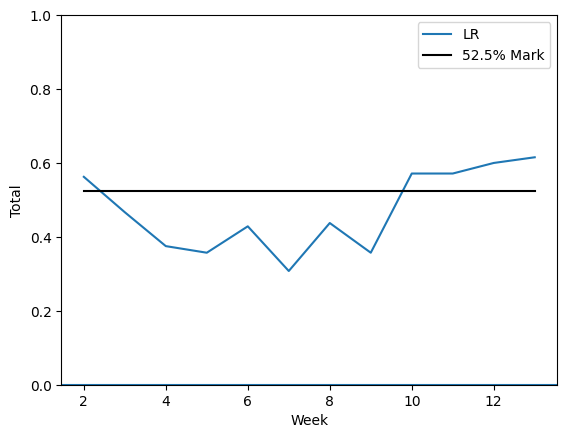

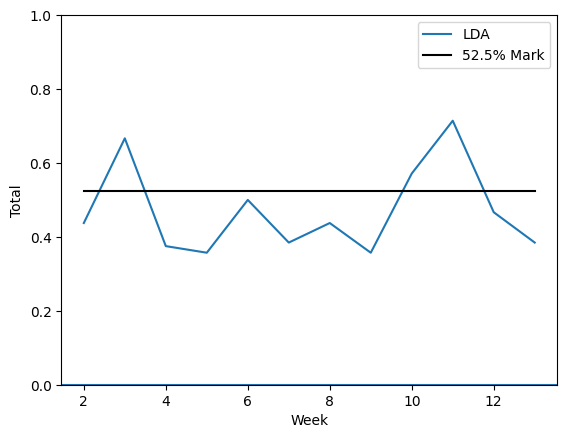

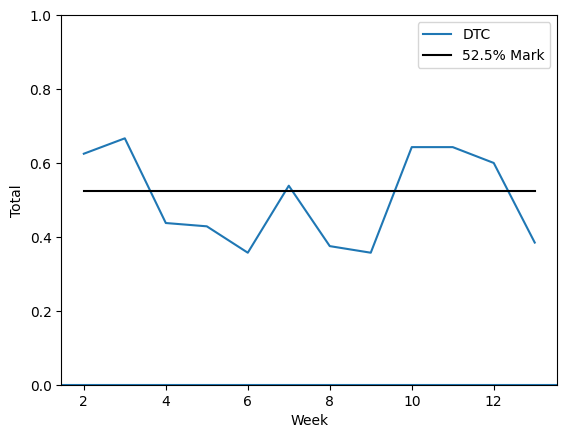

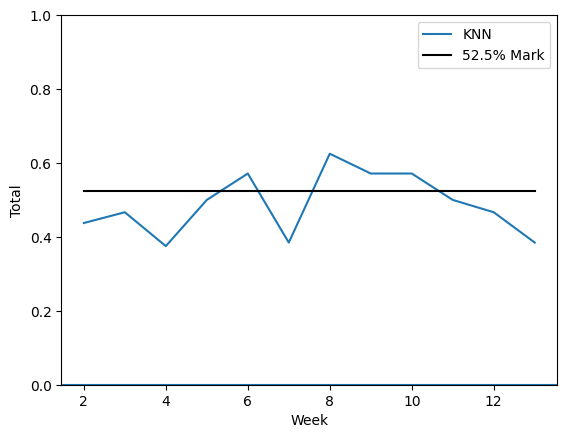

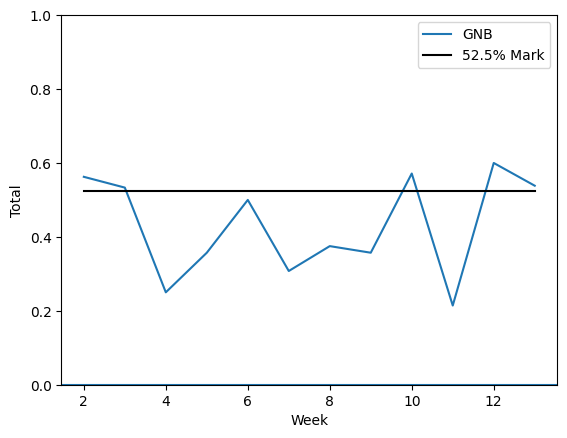

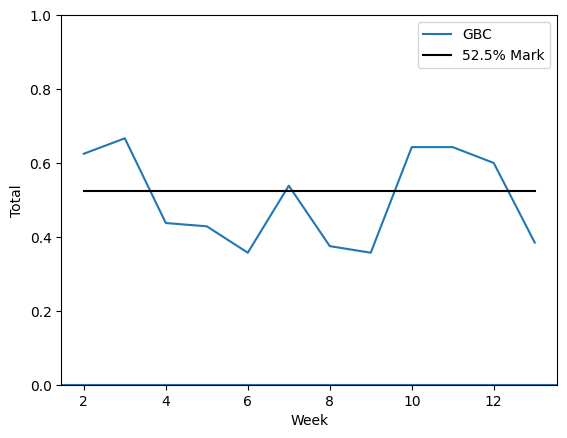

In [237]:
# Graph results
# Spread testing
graph_results(tags=tags, dictionary=spread_results)

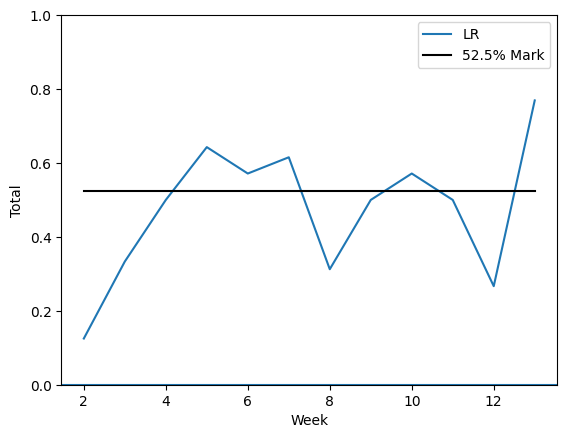

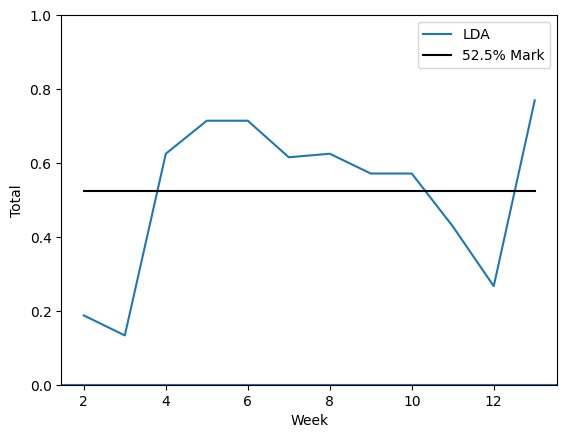

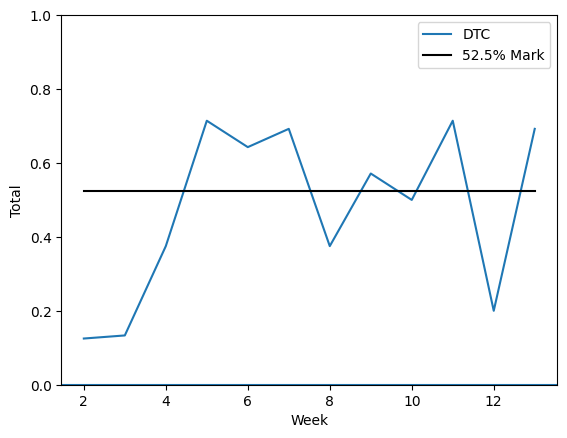

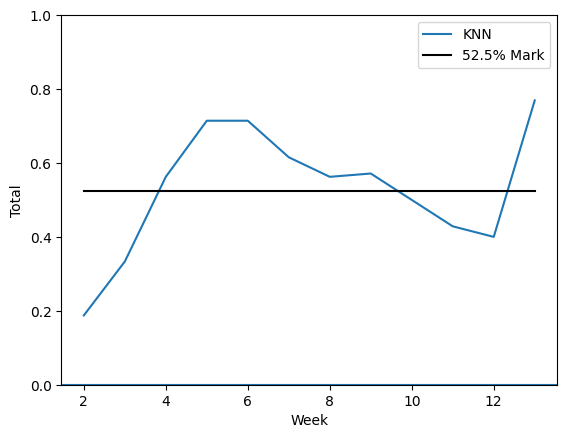

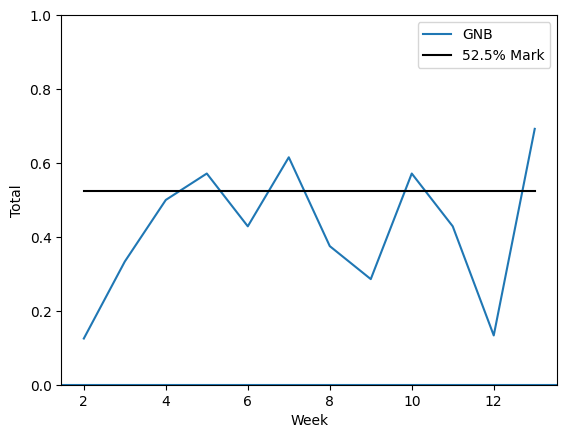

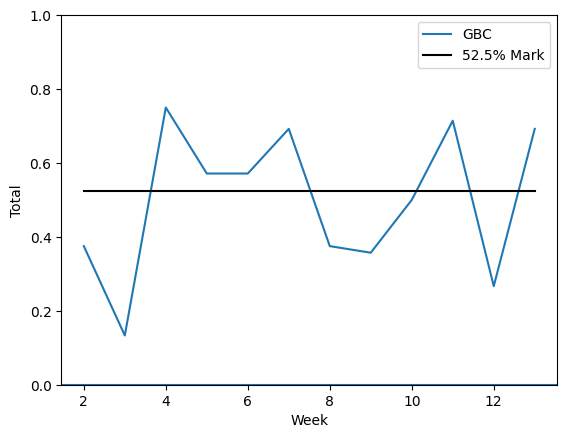

In [206]:
# Graph results (ou testing)
graph_results(tags=tags, dictionary=ou_results)